In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import math
import numpy as np
%matplotlib inline

In [2]:
from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [3]:
data_path = r'C:\Users\johnny.wong\PycharmProjects\NBA pricing\Personal\Data\nba_odds_raw.csv'
raw_odds = pd.read_csv(data_path)
raw_odds.head()

,YY,DD,MM,Seasons,Home team,Away team,Home ID,Away ID,End of regulation score,Home final score,Away final score,Winning team,Total score,Home odds 1,Away odds 1,Home odds 2,Away odds 2,Home odds 3,Away odds 3
0,2019,11,Feb,2018/2019,Golden State Warriors,Miami Heat,GSW,MIA,NaN,120.0,118.0,H,238.0,1.08,10.40,1.08,10.16,1.07,9.50
1,2019,11,Feb,2018/2019,Atlanta Hawks,Orlando Magic,ATL,ORL,NaN,108.0,124.0,A,232.0,2.06,1.62,2.04,1.87,2.20,1.71
2,2019,10,Feb,2018/2019,Sacramento Kings,Phoenix Suns,SAC,PHX,NaN,117.0,104.0,H,221.0,1.19,3.90,1.24,4.65,1.26,4.00
3,2019,10,Feb,2018/2019,Philadelphia 76ers,Los Angeles Lakers,PHI,LAL,NaN,143.0,120.0,H,263.0,1.33,3.00,1.34,3.56,1.34,3.35
4,2019,10,Feb,2018/2019,Dallas Mavericks,Portland Trail Blazers,DAL,POR,NaN,102.0,101.0,H,203.0,2.61,1.57,2.62,1.56,1.74,2.15


In [4]:
clean_odds = raw_odds.copy()
clean_odds['date_string'] = clean_odds.apply(lambda row:str(row.DD)+'-'+str(row.MM)+'-'+str(row.YY), axis=1)
clean_odds['Date'] = clean_odds.date_string.apply(lambda date_str: dt.datetime.strptime(date_str, '%d-%b-%Y'))

clean_odds['Avg_A_odds'] = clean_odds.apply(lambda row:np.nanmean([row['Away odds 1'], row['Away odds 2'], 
                                                                   row['Away odds 3']]), axis=1)
clean_odds['Avg_H_odds'] = clean_odds.apply(lambda row:np.nanmean([row['Home odds 1'], row['Home odds 2'], 
                                                                   row['Home odds 3']]), axis=1)

clean_odds['IP'] = 1/clean_odds.Avg_H_odds + 1/clean_odds.Avg_A_odds
clean_odds['Standardised_H_odds'] = clean_odds.Avg_H_odds * clean_odds.IP
clean_odds['Standardised_A_odds'] = clean_odds.Avg_A_odds * clean_odds.IP
clean_odds['Standardised_IP'] = 1/clean_odds['Standardised_H_odds'] + 1/clean_odds['Standardised_A_odds']
clean_odds['favourite_odds'] = clean_odds.apply(lambda row: min(row.Standardised_H_odds, row.Standardised_A_odds), axis=1)

# Remove bad data
clean_odds = clean_odds[raw_odds['Total score'] > 50]

clean_odds.head()

C:\Users\johnny.wong\.conda\envs\env1\lib\site-packages\numpy\lib\nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
C:\Users\johnny.wong\.conda\envs\env1\lib\site-packages\numpy\lib\nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
C:\Users\johnny.wong\.conda\envs\env1\lib\site-packages\numpy\lib\nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
C:\Users\johnny.wong\.conda\envs\env1\lib\site-packages\numpy\lib\nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
C:\Users\johnny.wong\.conda\envs\env1\lib\site-packages\numpy\lib\nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
C:\Users\johnny.wong\.conda\envs\env1\lib\site-packages\numpy\lib\nanfunctions.py:703: RuntimeWarning: Mean of

,YY,DD,MM,Seasons,Home team,Away team,Home ID,Away ID,End of regulation score,Home final score,Away final score,Winning team,Total score,Home odds 1,Away odds 1,Home odds 2,Away odds 2,Home odds 3,Away odds 3,date_string,Date,Avg_A_odds,Avg_H_odds,IP,Standardised_H_odds,Standardised_A_odds,Standardised_IP,favourite_odds
0,2019,11,Feb,2018/2019,Golden State Warriors,Miami Heat,GSW,MIA,NaN,120.0,118.0,H,238.0,1.08,10.40,1.08,10.16,1.07,9.50,11-Feb-2019,2019-02-11,10.020000,1.076667,1.028593,1.107452,10.306502,1.0,1.107452
1,2019,11,Feb,2018/2019,Atlanta Hawks,Orlando Magic,ATL,ORL,NaN,108.0,124.0,A,232.0,2.06,1.62,2.04,1.87,2.20,1.71,11-Feb-2019,2019-02-11,1.733333,2.100000,1.053114,2.211538,1.825397,1.0,1.825397
2,2019,10,Feb,2018/2019,Sacramento Kings,Phoenix Suns,SAC,PHX,NaN,117.0,104.0,H,221.0,1.19,3.90,1.24,4.65,1.26,4.00,10-Feb-2019,2019-02-10,4.183333,1.230000,1.052052,1.294024,4.401084,1.0,1.294024
3,2019,10,Feb,2018/2019,Philadelphia 76ers,Los Angeles Lakers,PHI,LAL,NaN,143.0,120.0,H,263.0,1.33,3.00,1.34,3.56,1.34,3.35,10-Feb-2019,2019-02-10,3.303333,1.336667,1.050854,1.404642,3.471322,1.0,1.404642
4,2019,10,Feb,2018/2019,Dallas Mavericks,Portland Trail Blazers,DAL,POR,NaN,102.0,101.0,H,203.0,2.61,1.57,2.62,1.56,1.74,2.15,10-Feb-2019,2019-02-10,1.760000,2.323333,0.998598,2.320076,1.757532,1.0,1.757532


In [5]:
clean_odds[(clean_odds.Standardised_IP - 1).abs() > 0.01]

,YY,DD,MM,Seasons,Home team,Away team,Home ID,Away ID,End of regulation score,Home final score,Away final score,Winning team,Total score,Home odds 1,Away odds 1,Home odds 2,Away odds 2,Home odds 3,Away odds 3,date_string,Date,Avg_A_odds,Avg_H_odds,IP,Standardised_H_odds,Standardised_A_odds,Standardised_IP,favourite_odds


Plot the home winning margin against the home implied probabilities

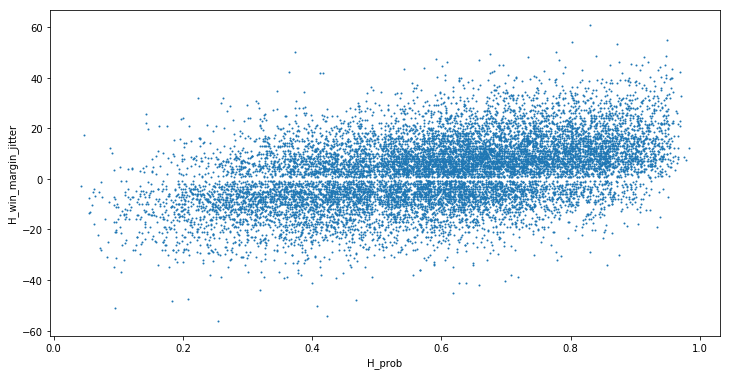

In [15]:
clean_odds['H_prob'] = 1/clean_odds['Standardised_H_odds']
clean_odds['A_prob'] = 1/clean_odds['Standardised_A_odds']
clean_odds['H_win_margin'] = clean_odds['Home final score'] - clean_odds['Away final score']
clean_odds['H_win_margin_jitter'] = clean_odds['H_win_margin'] + np.random.normal(scale=0.2, size=len(clean_odds))
clean_odds.plot(x='H_prob', y='H_win_margin_jitter', kind='scatter', figsize=(12, 6), s=1)

Clear relationship between the probability of a 